In [3]:
# Final input
# CellGroups
# TreeStructure

In [4]:
#GRNtree function
GRNtree <- function(CellGroups, TreeStructure, alpha = 0.5, figure = F){ # a function to calculate the 
    library(Matrix)
    library(glmnet)
    
    numofgruops <- length(CellGroups) # K and p
    numoftargets <- ncol(CellGroups[[1]]$X)
    numofsamples <- sum( sapply(CellGroups, function(node) length(node$y)) )
    
    X <- Matrix(0.0, ncol = numoftargets*numofgruops
                , nrow = numofsamples) # R^K\times(p*K)
    y <- Matrix(0.0, ncol = 1, nrow = numofsamples)
                           
    rsplit <- c(0, cumsum(sapply(CellGroups, function(node) length(node$y))) )
    csplit <- (0:numofgruops)*numoftargets
                                 
    for( ii in 1:numofgruops){
        X[ (rsplit[ii]+1):rsplit[ii+1], (csplit[ii]+1):csplit[ii+1]] <- CellGroups[[ii]]$X
        y[(rsplit[ii]+1):rsplit[ii+1]] <- CellGroups[[ii]]$y
    }

    # print(sum(X)==sum(sapply(CellGroups, function(node) sum(node$X))))
    
    D1 <-  diag(numofgruops)
    edgeslist <-  which(TreeStructure!=0, arr.ind = T)
    D2 <- Matrix(0.0, ncol = numofgruops, nrow = nrow(edgeslist))
    for(ii in 1:nrow(D2)){
        D2[ii, edgeslist[ii,1]] <- 1
        D2[ii, edgeslist[ii,2]] <- -1
    }                     
    D <- Matrix( rbind(alpha*D1, (1-alpha)*D2), sparse = T)
    Dinv <- solve(t(D)%*%D)%*%t(D)                         
    Dinvkro <- kronecker( Dinv, diag(numoftargets))
                             
    Xp <- X%*%Dinvkro
                             
    cvglm <- cv.glmnet(x = Xp, y = y, intercept = T ) 
    beta.cvglm <- coef(cvglm,s = cvglm$lambda.min)[-1]
    b.cvglm <- as.numeric(Dinvkro%*% beta.cvglm)
    if(figure ==T) {
        plot(cvglm)
    }                         
#   print(cvglm$glm)                             
    normofXs <- sapply(CellGroups, function(node) apply(node$X, 2, function(xi) sqrt(sum(xi^2)) ) )
    normofys <- sapply(CellGroups, function(node) sqrt(sum(node$y^2)) ) 
    
    normofXs.vec <- as.numeric(normofXs)                   
    normofys.vec <- rep(normofys,each = numoftargets)
    
#    return(list(GRNs = b.cvglm, scaledGRNs = b.cvglm*normofXs.vec/normofys.vec))
                       
    GRNs <- Matrix(b.cvglm,ncol = numofgruops, byrow = F, sparse = T 
                   ,dimnames = list(colnames(CellGroups[[1]]$X), names(CellGroups)) )
    scaledGRNs <- Matrix(b.cvglm*normofXs.vec/normofys.vec, ncol = numofgruops, byrow = F, sparse = T
                        ,dimnames = list(colnames(CellGroups[[1]]$X), names(CellGroups)) )  
    return( list(GRNs = GRNs, scaledGRNs =  scaledGRNs))
                       
}

# Read the raw data

In [5]:
# Read data including the rpkm data and the cell type identification of cells
meta.mat <- read.table('/stor/shiming/data/petropoulos_humanembryodynamics_Cell_2016/E-MTAB-3929.sdrf.txt'
                       , sep = '\t', as.is = T, header = T)
rpkm.mat <- read.table('/stor/shiming/data/petropoulos_humanembryodynamics_Cell_2016/rpkm.txt', as.is = T)
rpkm.mat <- rpkm.mat[,meta.mat$Extract.Name] #order the cells in rpkm.mat as those in meta.dat

str(rpkm.mat)
str(meta.mat)

'data.frame':	26178 obs. of  1529 variables:
 $ E3.1.443        : num  68.6 8.53 1.69 0 0 ...
 $ E3.1.444        : num  17.0866 0 0.0953 0 0 ...
 $ E3.1.445        : num  81.24 4.58 2.65 0 0 ...
 $ E3.1.447        : num  69.532 0 0.0455 0 0 ...
 $ E3.1.448        : num  24.8 0 4.26 0 0 ...
 $ E3.2.449        : num  68.87 7.34 2.79 0 0 ...
 $ E3.2.450        : num  153.663 3.558 2.055 0 0.493 ...
 $ E3.2.452        : num  0.231 0 3.731 0 0 ...
 $ E3.2.453        : num  4.63 0 5.69 0 0 ...
 $ E3.2.454        : num  18.6961 0 2.6463 0.0843 0 ...
 $ E3.2.455        : num  0 0 2.51 0 0 ...
 $ E3.2.466        : num  0 0 0 0 0 ...
 $ E3.2.467        : num  0 0 0 0 0 ...
 $ E3.3.456        : num  0 0 0 0 0 ...
 $ E3.3.457        : num  87.56 1.37 1.49 0 0 ...
 $ E3.3.458        : num  69 10.6 0 0 0 ...
 $ E3.3.459        : num  59.31 4.9 1.28 0 0 ...
 $ E3.3.460        : num  27.494 2.412 0.183 0 0 ...
 $ E3.4.462        : num  5.15 0 1.81 0 0 ...
 $ E3.4.463        : num  0 0 3.65 0 0 ...
 $ 

In [6]:
# celltypes <- paste(meta.mat$Characteristics.developmental.stage.
#                   , meta.mat$Characteristics.inferred.lineage.
#                   , sep = '-')
# unique(celltypes)

ds <- gsub('embryonic day ', 'E', meta.mat$Characteristics.developmental.stage. , fixed = TRUE)
il <- gsub( 'epiblast', 'EPI', meta.mat$Characteristics.inferred.lineage., fixed = TRUE)
il2 <- gsub( 'trophectoderm', 'TE', il, fixed = TRUE)
il3 <- gsub( 'primitive endoderm', 'PE', il2, fixed = TRUE)

celltypes <- paste( ds, il3, sep = '-')

celltypes[ celltypes=='E3-not applicable'] = 'E3'
celltypes[ celltypes=='E4-not applicable'] = 'E4'

table(celltypes)

celltypes
               E3                E4            E5-EPI E5-not applicable 
               81               190                41               162 
            E5-PE             E5-TE            E6-EPI             E6-PE 
               32               142                45                39 
            E6-TE            E7-EPI             E7-PE             E7-TE 
              331                41                37               388 

In [7]:
# truncate the rpkm.mat and meta.mat data
rpkm.mat <- rpkm.mat[, !(celltypes=='E5-not applicable')] 
meta.mat <- meta.mat[!(celltypes=='E5-not applicable'), ] 
celltypes <- celltypes[ !(celltypes=='E5-not applicable')]


# Human tfs 

In [8]:
htfdata <-  read.csv('/stor/shiming/data/BEELINE/BEELINE-Networks/human-tfs.csv', as.is = T)                                                                                    
str(htfdata)
htf <- intersect( htfdata$TF, rownames(rpkm.mat) )
str(htf)
X <- rpkm.mat[htf, ]
dim(X)

'data.frame':	1563 obs. of  2 variables:
 $ TF     : chr  "AATF" "ABL1" "ABT1" "ABTB1" ...
 $ Sources: chr  "RegNetwork|TRRUST" "RegNetwork|TRRUST" "RegNetwork" "RegNetwork" ...
 chr [1:1527] "AATF" "ABL1" "ABT1" "ABTB1" "ADNP" "AEBP1" "AEBP2" "AES" ...


[1] 1527 1367

In [9]:
hpmarkergenes <-  c('PRDM14', 'GDF3', 'TDGF1', 'NODAL', 'SOX2', 'NANOG' # EPI
  , 'COL4A1', 'HNF1B', 'PDGFRA', 'GATA4', 'FN1') # PE
Y <- rpkm.mat[hpmarkergenes, ]
dim(Y)

[1]   11 1367

In [10]:
X <- t(X)
Y <- t(Y)
rbind( dim(X), dim(Y) )

1367,1527
1367,11


# TreeStructure

In [11]:
library(Matrix)
TreeStructure <- Matrix(0.0, ncol = 11, nrow = 11) # K is 11, the number of cell types
rownames(TreeStructure) <- c('E3', 'E4', 'E5-EPI', 'E6-EPI', 'E7-EPI'
                                       , 'E5-TE',  'E6-TE',  'E7-TE'
                                       , 'E5-PE',  'E6-PE',  'E7-PE')
colnames(TreeStructure) <- rownames(TreeStructure)

TreeStructure['E3', 'E4'] <-1

TreeStructure['E4', 'E5-EPI'] <- 1
TreeStructure['E4', 'E5-TE'] <-1
TreeStructure['E4', 'E5-PE']<-1

TreeStructure['E5-EPI', 'E6-EPI'] <- 1
TreeStructure['E5-TE', 'E6-TE'] <-1
TreeStructure['E5-PE', 'E6-PE']<-1

TreeStructure['E6-EPI', 'E7-EPI'] <- 1
TreeStructure['E6-TE', 'E6-TE'] <-1
TreeStructure['E7-PE', 'E7-PE']<-1

TreeStructure
sum(TreeStructure)

   [[ suppressing 11 column names ‘E3’, ‘E4’, ‘E5-EPI’ ... ]]


11 x 11 sparse Matrix of class "dgCMatrix"
                            
E3     . 1 . . . . . . . . .
E4     . . 1 . . 1 . . 1 . .
E5-EPI . . . 1 . . . . . . .
E6-EPI . . . . 1 . . . . . .
E7-EPI . . . . . . . . . . .
E5-TE  . . . . . . 1 . . . .
E6-TE  . . . . . . 1 . . . .
E7-TE  . . . . . . . . . . .
E5-PE  . . . . . . . . . 1 .
E6-PE  . . . . . . . . . . .
E7-PE  . . . . . . . . . . 1

[1] 10

# Calculation

In [12]:
# input for calculation: 
# expression of tfs : X
# expression of target genes : Y
# cell types : celltypes
# cell type tree structure: TreeStructure
str(X)
str(Y)
str(TreeStructure)
identical(rownames(X), rownames(Y))

 num [1:1367, 1:1527] 25.6 22.5 21.5 31.6 41.1 ...
 - attr(*, "dimnames")=List of 2
  ..$ : chr [1:1367] "E3.1.443" "E3.1.444" "E3.1.445" "E3.1.447" ...
  ..$ : chr [1:1527] "AATF" "ABL1" "ABT1" "ABTB1" ...
 num [1:1367, 1:11] 0 8.37 7.23 0 0 ...
 - attr(*, "dimnames")=List of 2
  ..$ : chr [1:1367] "E3.1.443" "E3.1.444" "E3.1.445" "E3.1.447" ...
  ..$ : chr [1:11] "PRDM14" "GDF3" "TDGF1" "NODAL" ...
Formal class 'dgCMatrix' [package "Matrix"] with 6 slots
  ..@ i       : int [1:10] 0 1 2 3 1 5 6 1 8 10
  ..@ p       : int [1:12] 0 0 1 2 3 4 5 7 7 8 ...
  ..@ Dim     : int [1:2] 11 11
  ..@ Dimnames:List of 2
  .. ..$ : chr [1:11] "E3" "E4" "E5-EPI" "E6-EPI" ...
  .. ..$ : chr [1:11] "E3" "E4" "E5-EPI" "E6-EPI" ...
  ..@ x       : num [1:10] 1 1 1 1 1 1 1 1 1 1
  ..@ factors : list()


[1] TRUE

In [13]:
grntreeList <- vector( mode = 'list', length = ncol(Y))
names(grntreeList) <- colnames(Y)

for ( ii in 1:ncol(Y)){
    target <- colnames(Y)[ii]
    print(target)
    
    ynew <- Y[,target]
    Xnew <- X[, colnames(X) != target]
    
    CellGroups <- vector( mode = 'list', length = ncol(TreeStructure))
    names(CellGroups) <- colnames(TreeStructure)

    #str(CellGroups)

    for( nodeid in 1:length(CellGroups)){
        CellGroups[[nodeid]]$X <- Xnew[ celltypes ==names(CellGroups)[nodeid], ]
        CellGroups[[nodeid]]$y <- ynew[ celltypes ==names(CellGroups)[nodeid] ]
    }

    grntree <- GRNtree( CellGroups, TreeStructure , alpha = 0.5, figure = F)   
    
    grntreeList[[ii]] <- grntree$scaledGRNs

}

[1] "PRDM14"


Loading required package: foreach
Loaded glmnet 2.0-16



[1] "GDF3"
[1] "TDGF1"
[1] "NODAL"
[1] "SOX2"
[1] "NANOG"
[1] "COL4A1"
[1] "HNF1B"
[1] "PDGFRA"
[1] "GATA4"
[1] "FN1"


# Evaluate on benchmark regulation

In [14]:
benchmarkregulation1 <- read.csv('/stor/shiming/data/BEELINE//BEELINE-Networks//Networks//human//HepG2-ChIP-seq-network.csv'
                               , as.is = T)
benchmarkregulation2 <- read.csv('/stor/shiming/data/BEELINE//BEELINE-Networks//Networks//human//hESC-ChIP-seq-network.csv'
                               , as.is = T)
benchmarkregulation3 <- read.csv('/stor/shiming/data/BEELINE//BEELINE-Networks//Networks//human//Non-specific-ChIP-seq-network.csv'
                               , as.is = T)
benchmarkregulation4 <- read.csv('/stor/shiming/data/BEELINE//BEELINE-Networks//Networks//human//STRING-network.csv'
                               , as.is = T)
str(benchmarkregulation1)

benchmarkregulation <- rbind( rbind( 
                            rbind(benchmarkregulation1, benchmarkregulation2)
                            ,benchmarkregulation3)
                            , benchmarkregulation4)
str(benchmarkregulation)

'data.frame':	342862 obs. of  2 variables:
 $ Gene1: chr  "ARID1A" "ARID1A" "ARID1A" "ARID1A" ...
 $ Gene2: chr  "KAT7" "NUP107" "MCRIP1" "NFKBIA" ...
'data.frame':	1364003 obs. of  2 variables:
 $ Gene1: chr  "ARID1A" "ARID1A" "ARID1A" "ARID1A" ...
 $ Gene2: chr  "KAT7" "NUP107" "MCRIP1" "NFKBIA" ...


In [15]:
inferredregulation <- NULL
for( ii in 1:length(grntreeList)){
    #print(names(grntreeList)[ii])
    scaledgrntree <- grntreeList[[ii]]
    validsgt <- as.matrix ( scaledgrntree[ apply( abs(scaledgrntree), 1, sum) !=0, ])
    inferredregulation <- rbind( inferredregulation, cbind(rownames(validsgt), names(grntreeList)[ii]))
    #print(dim(validsgt))
}
str(inferredregulation)

 chr [1:579, 1:2] "ASH2L" "CITED2" "CREB1" "DLX4" "EHF" "FOXD3" "FOXF1" ...


In [16]:
tf2gene <- which( paste(inferredregulation[,1], inferredregulation[,2], sep = "+") %in%
                 paste(benchmarkregulation[,1], benchmarkregulation[,2], sep = '+') )

length(tf2gene)
length(tf2gene)/nrow(inferredregulation)

inferredregulation[tf2gene,]

[1] 48

[1] 0.08290155

CREB1,PRDM14
NANOG,PRDM14
PBX1,PRDM14
POU5F1,PRDM14
SOX2,PRDM14
NANOG,GDF3
SOX2,GDF3
BCOR,TDGF1
NANOG,TDGF1
SOX2,TDGF1
ZIC3,TDGF1


In [17]:
#saveRDS(object = grntreeList, file = 'grntreeList22Dec766_75.RDS')

In [25]:
str(scaledGRNs)
colnames(scaledGRNs)

Formal class 'dgCMatrix' [package "Matrix"] with 6 slots
  ..@ i       : int [1:344] 57 153 169 220 260 331 333 408 409 424 ...
  ..@ p       : int [1:12] 0 38 76 115 153 190 229 268 268 306 ...
  ..@ Dim     : int [1:2] 1526 11
  ..@ Dimnames:List of 2
  .. ..$ : chr [1:1526] "AATF" "ABL1" "ABT1" "ABTB1" ...
  .. ..$ : chr [1:11] "E3" "E4" "E5-EPI" "E6-EPI" ...
  ..@ x       : num [1:344] 4.86e-02 -6.02e-05 5.36e-02 2.50e-04 8.24e-03 ...
  ..@ factors : list()


[1] "E3"     "E4"     "E5-EPI" "E6-EPI" "E7-EPI" "E5-TE"  "E6-TE"  "E7-TE" 
 [9] "E5-PE"  "E6-PE"  "E7-PE"

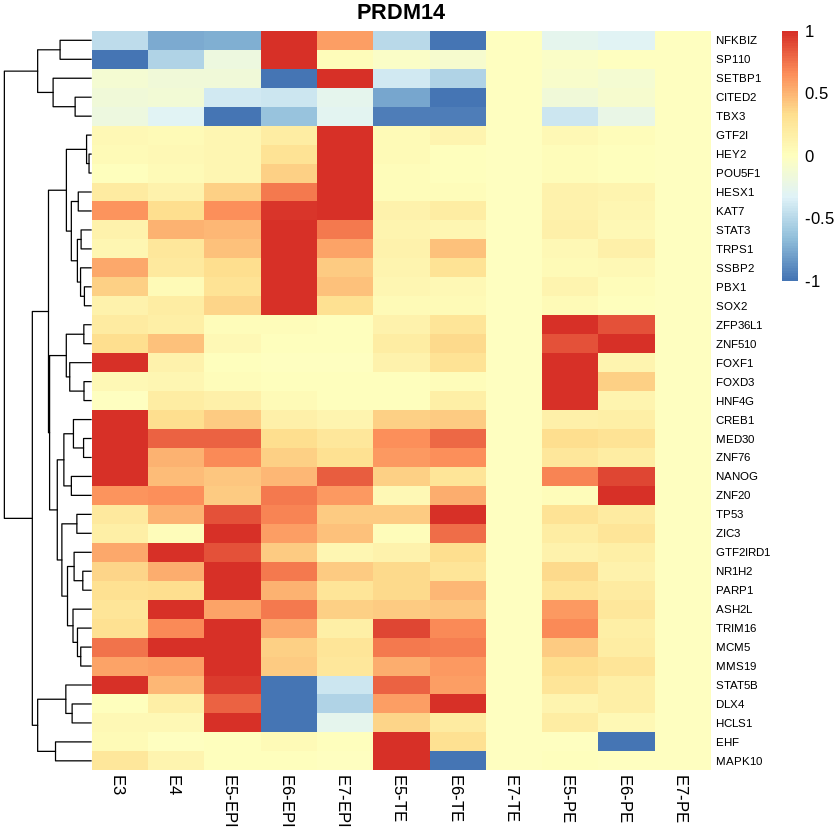

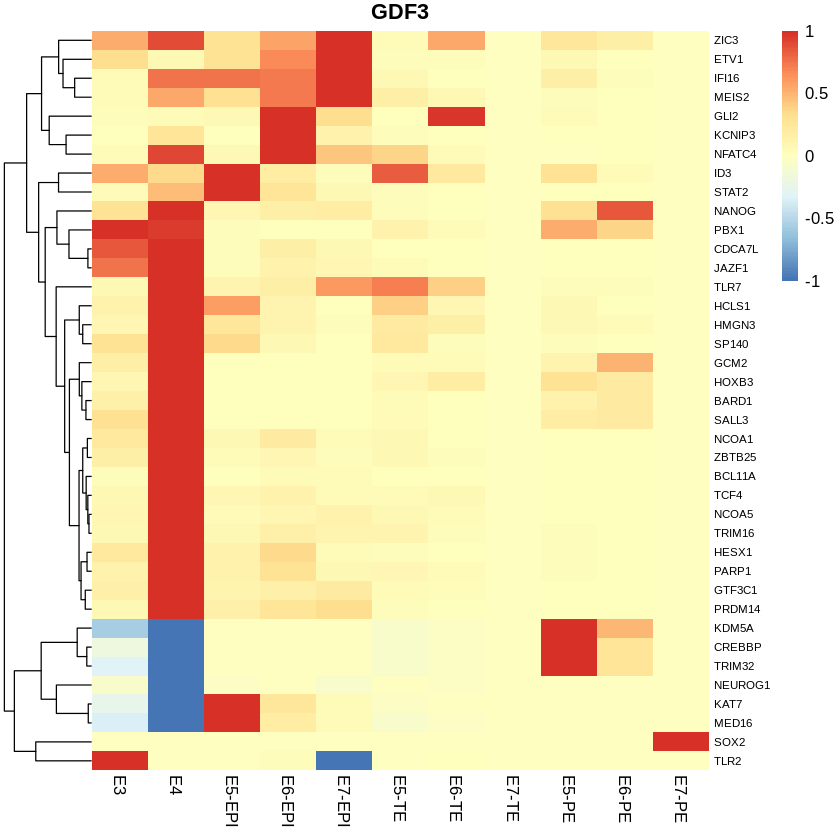

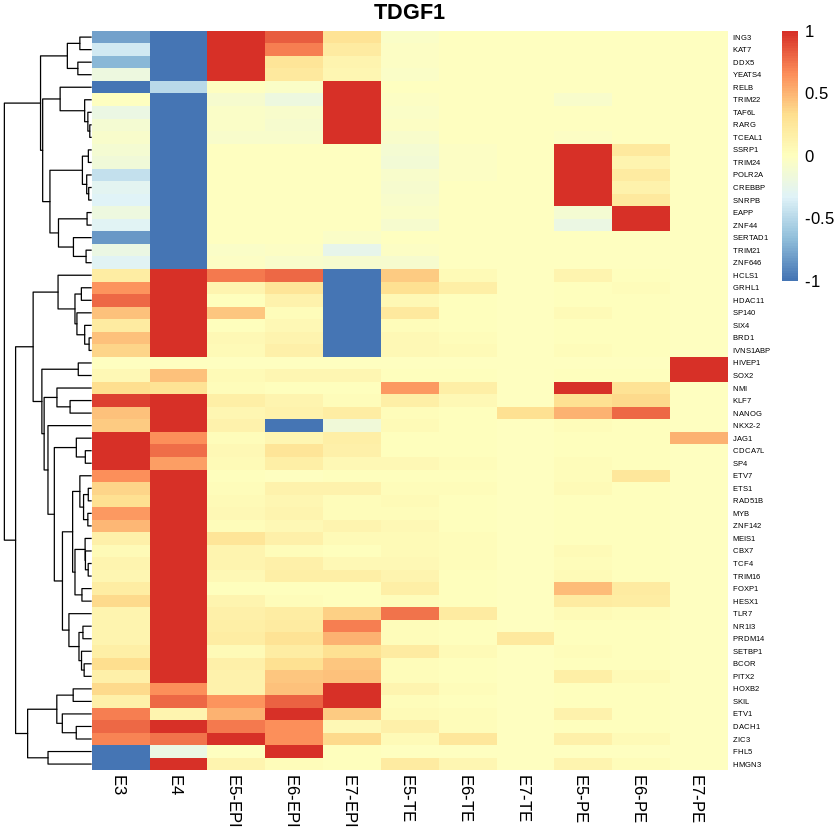

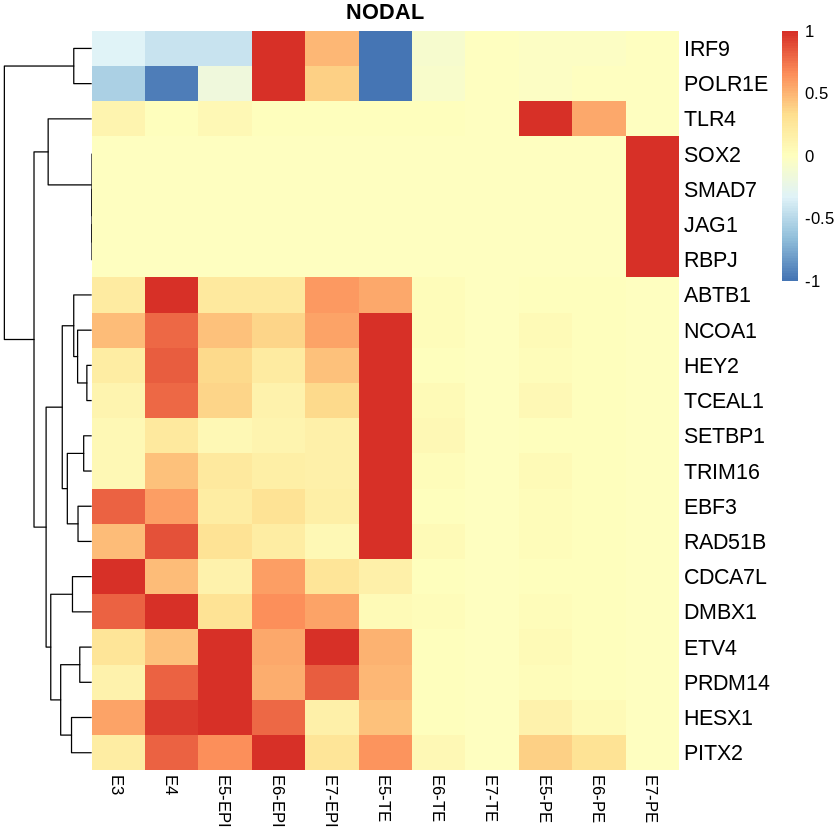

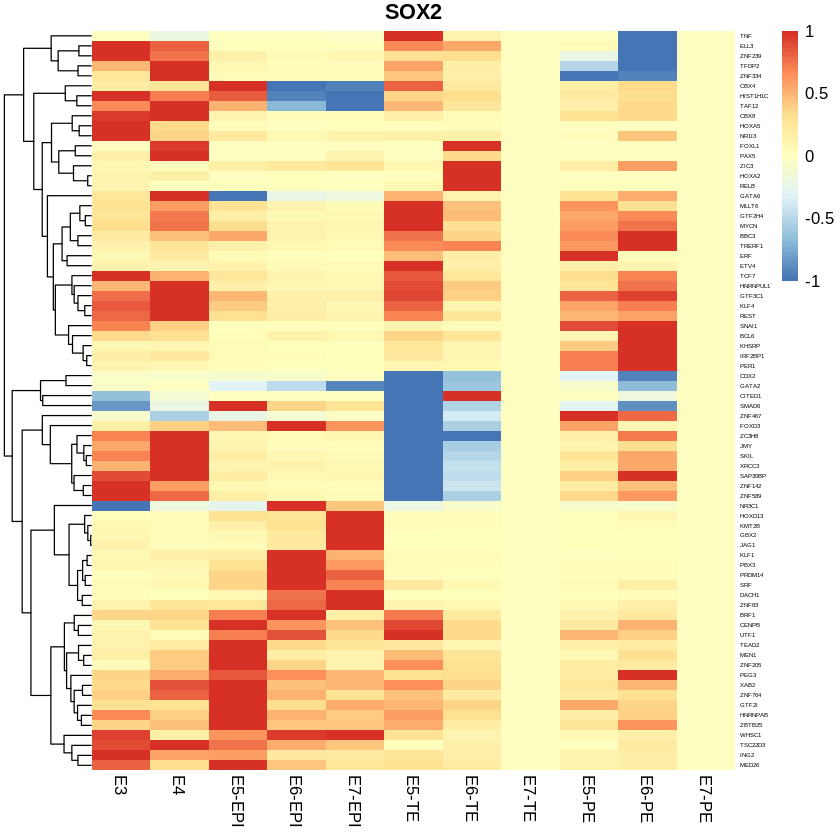

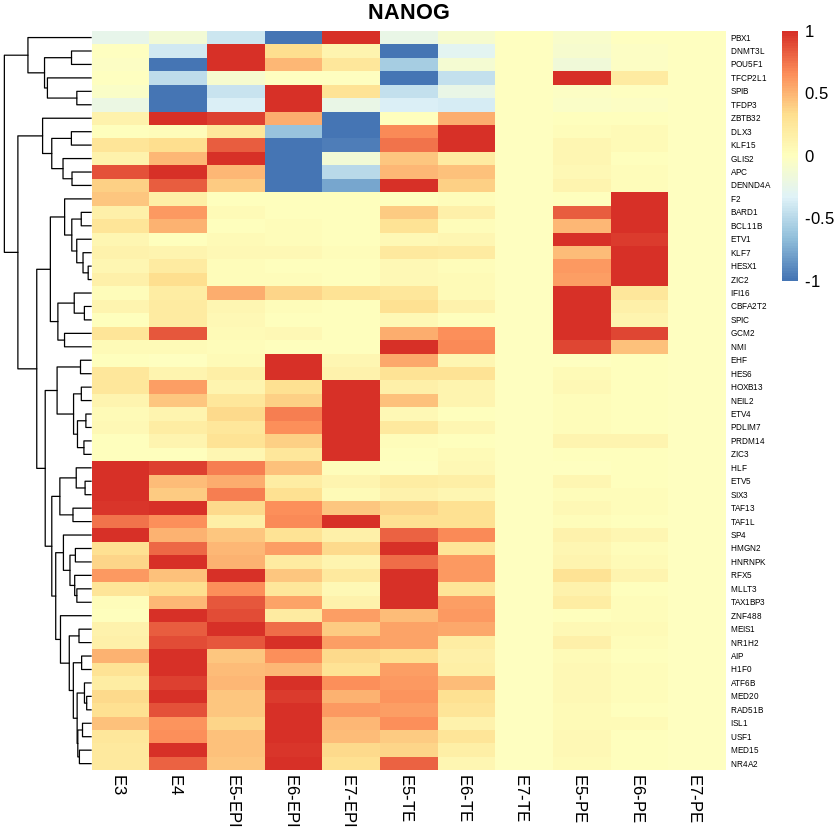

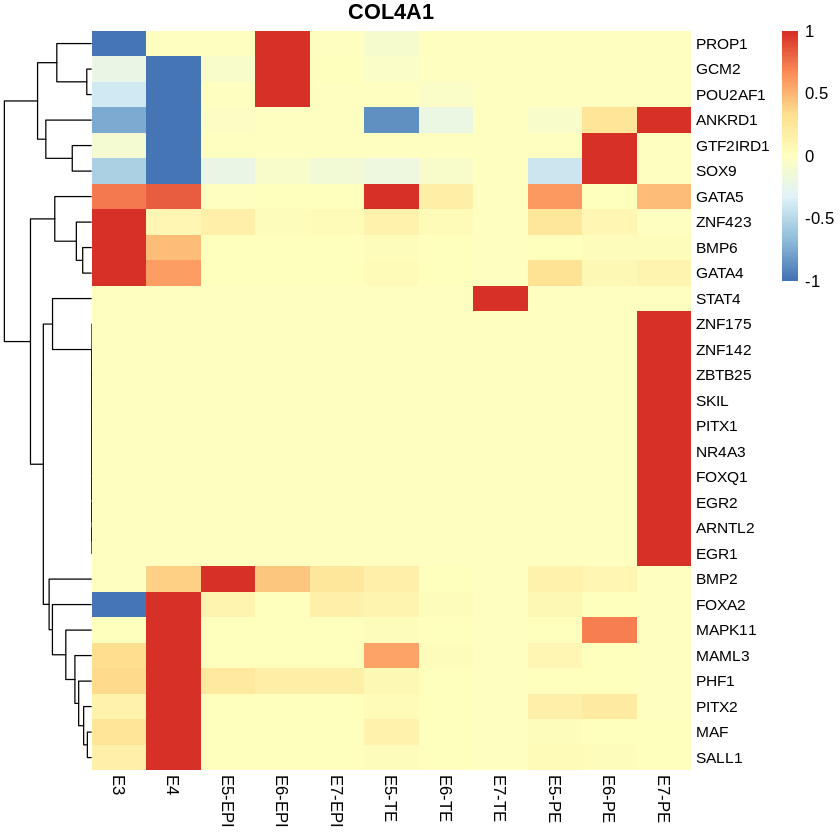

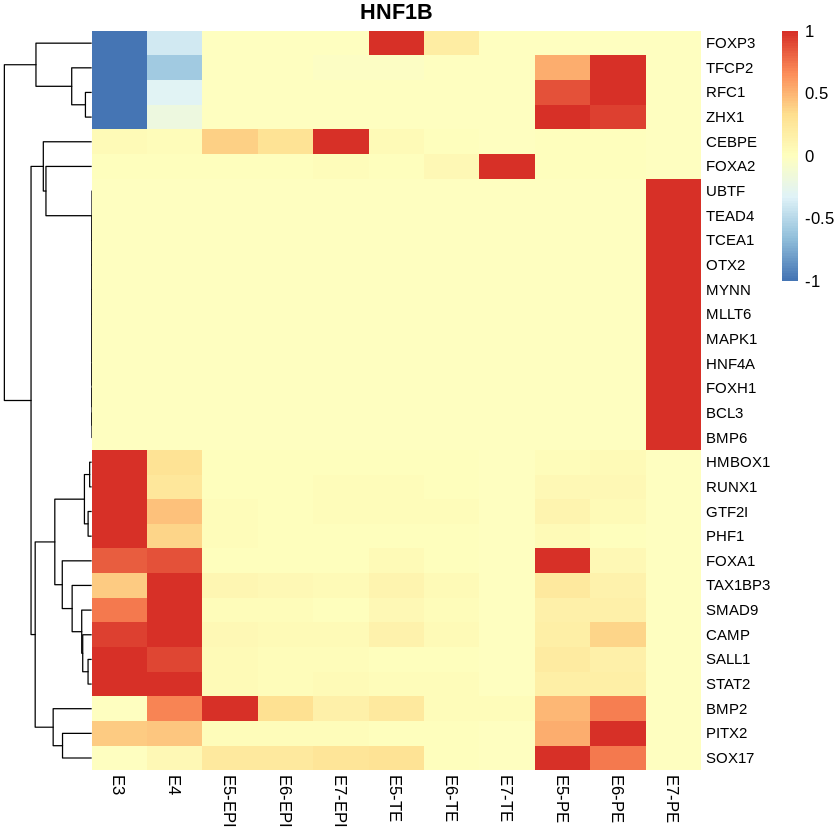

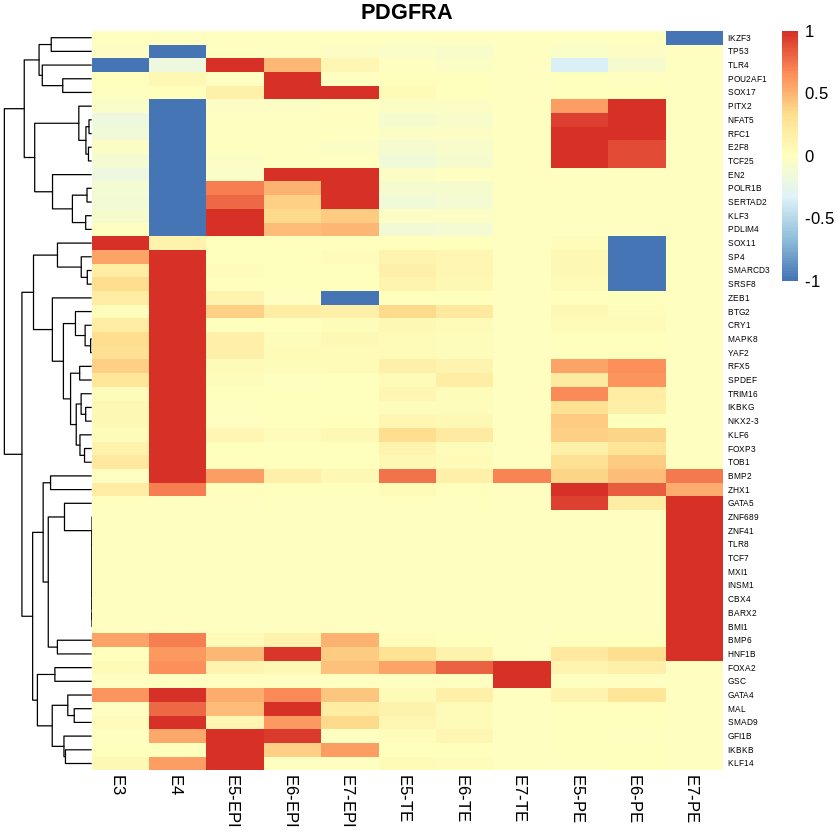

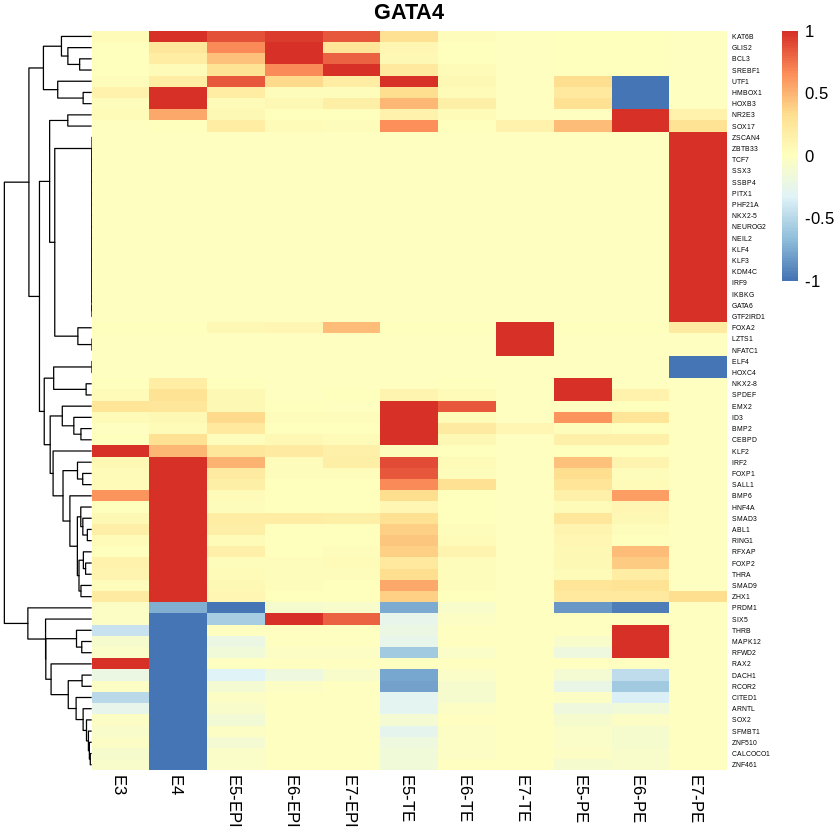

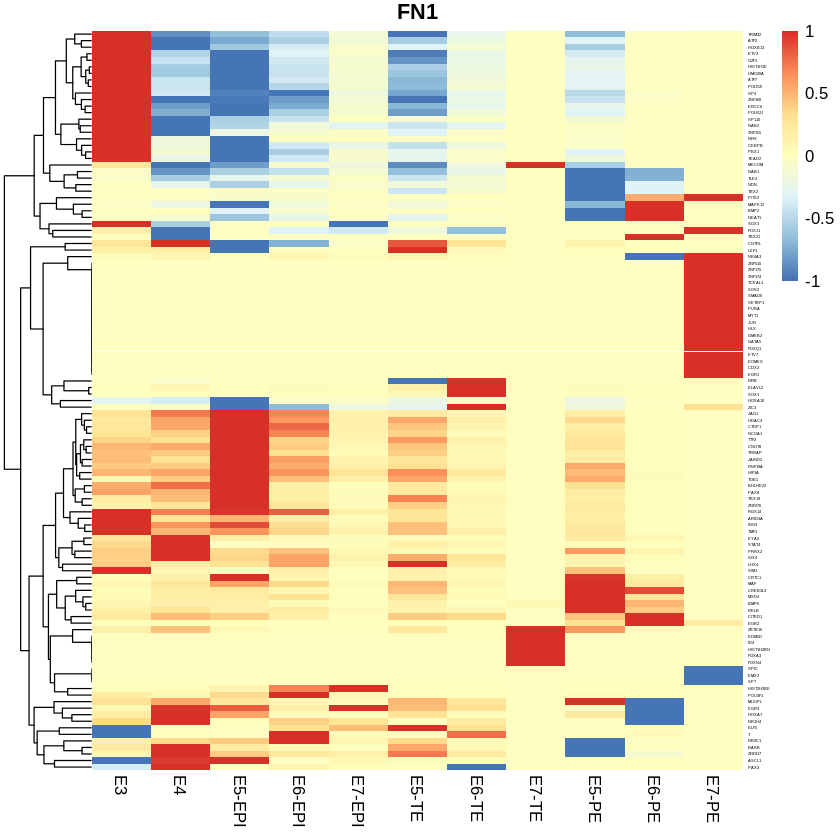

In [26]:
#pdf(file = 'human_embryos_markers3.pdf', width = 7, height = 7 )
#par(mfrow = c(4,3))
for( ii in 1:length(grntreeList)){
    scaledGRNs <- grntreeList[[ii]]
    
    scaledGRNs[ is.na(scaledGRNs)] <-0
    scaledGRNs[!is.finite(scaledGRNs)] <- 0
    
    validGRNs <- as.matrix( scaledGRNs[ apply(abs(scaledGRNs),1,sum)!=0, ])
    
    
    # print(dim(validGRNs))
    
    
    #library(pheatmap)
    #pheatmap(validGRNs, fontsize_row = 3, border = FALSE, cluster_cols = F)
    
    svalidGRNs <- matrix(0.0, nrow = nrow(validGRNs), ncol = ncol(validGRNs)
                         ,dimnames = list(rownames(validGRNs),colnames(validGRNs)))
    
    for(row in 1:nrow(validGRNs)){
        pids <- which(validGRNs[row,]>0)
        nids <- which(validGRNs[row,]<0)
        
        if(length(pids)>0){
            svalidGRNs[row, pids] <- validGRNs[row,pids]/max(validGRNs[row,pids])
        }
        if(length(nids)>0){
            svalidGRNs[row, nids] <- -validGRNs[row, nids]/min(validGRNs[row, nids])
        }
    }
    
     library(pheatmap)
     pheatmap(svalidGRNs, fontsize_row = 9*30/nrow(svalidGRNs), border = FALSE, cluster_cols = F
              , scale = 'none'
              ,main = names(grntreeList)[ii])
    #heatmap(svalidGRNs,Colv = NA, main = names(grntreeList)[ii], cexRow = 20/nrow(svalidGRNs)
    #        ,scale = 'none')
}
#dev.off()

In [50]:
#pdf(file = 'human_embryos_markers3.pdf', width = 7, height = 7 )
#par(mfrow = c(4,3))
regulation_summary <- matrix(0.0, nrow = length(grntreeList), ncol = ncol(TreeStructure) )
rownames(regulation_summary) <- names(grntreeList)
colnames(regulation_summary) <- colnames(TreeStructure)
str(regulation_summary)
for( ii in 1:length(grntreeList)){
    scaledGRNs <- grntreeList[[ii]]
    
    scaledGRNs[ is.na(scaledGRNs)] <-0
    scaledGRNs[!is.finite(scaledGRNs)] <- 0
    
    validGRNs <- as.matrix( scaledGRNs[ apply(abs(scaledGRNs),1,sum)!=0, ])
    
    
    # print(dim(validGRNs))
    
    
    #library(pheatmap)
    #pheatmap(validGRNs, fontsize_row = 3, border = FALSE, cluster_cols = F)
    
    svalidGRNs <- matrix(0.0, nrow = nrow(validGRNs), ncol = ncol(validGRNs)
                         ,dimnames = list(rownames(validGRNs),colnames(validGRNs)))
    
    for(row in 1:nrow(validGRNs)){
        pids <- which(validGRNs[row,]>0)
        nids <- which(validGRNs[row,]<0)
        
        if(length(pids)>0){
            svalidGRNs[row, pids] <- validGRNs[row,pids]/max(validGRNs[row,pids])
        }
        if(length(nids)>0){
            svalidGRNs[row, nids] <- -validGRNs[row, nids]/min(validGRNs[row, nids])
        }
    }
    regulation_summary[ii, ] <- apply( abs(svalidGRNs), 2, sum)
    
}
#dev.off()

regulationData <- data.frame(y = rep(rownames(regulation_summary), times = ncol(regulation_summary))
                            ,x = rep(colnames(regulation_summary),each = nrow(regulation_summary))
                            , height = as.numeric(regulation_summary)/max(regulation_summary)
                            ,stringsAsFactors = FALSE)


 num [1:11, 1:11] 0 0 0 0 0 0 0 0 0 0 ...
 - attr(*, "dimnames")=List of 2
  ..$ : chr [1:11] "PRDM14" "GDF3" "TDGF1" "NODAL" ...
  ..$ : chr [1:11] "E3" "E4" "E5-EPI" "E6-EPI" ...


In [51]:
str(regulationData)

'data.frame':	121 obs. of  3 variables:
 $ y     : chr  "PRDM14" "GDF3" "TDGF1" "NODAL" ...
 $ x     : chr  "E3" "E3" "E3" "E3" ...
 $ height: num  0.29 0.186 0.453 0.12 0.584 ...


In [54]:
regulationData$y[1:11]

[1] "PRDM14" "GDF3"   "TDGF1"  "NODAL"  "SOX2"   "NANOG"  "COL4A1" "HNF1B" 
 [9] "PDGFRA" "GATA4"  "FN1"

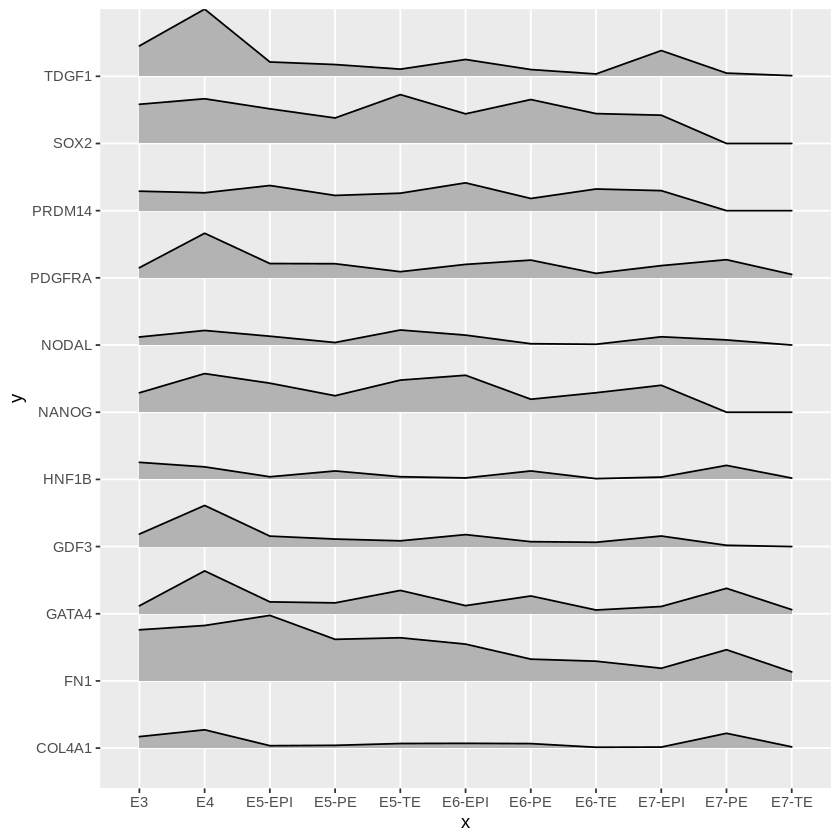

In [56]:
library(ggplot2)
library(ggridges)  # 绘制山脊图
ggplot(regulationData, aes(x = x, y = y, height = height, group =  y)) +
geom_ridgeline(stat = "identity")